In [1]:
!python -c "import torch; print(torch.__version__)"

2.0.1+cu118


In [2]:
!python -c "import torch; print(torch.version.cuda)"

11.8


In [3]:
!export TORCH=2.0.1+cu118
!export CUDA=11.8

In [ ]:
!pip install torch-geometric

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
GDRIVE_DIR = "/content/gdrive/My Drive/HW3"

Mounted at /content/gdrive


In [5]:
#%%
import requests
import os
from torch_geometric.data import Dataset
import torch


class HW3Dataset(Dataset):
    url = 'https://technionmail-my.sharepoint.com/:u:/g/personal/ploznik_campus_technion_ac_il/EUHUDSoVnitIrEA6ALsAK1QBpphP5jX3OmGyZAgnbUFo0A?download=1'

    def __init__(self, root, transform=None, pre_transform=None):
        super(HW3Dataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return ['data.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        file_url = self.url.replace(' ', '%20')
        response = requests.get(file_url)

        if response.status_code != 200:
            raise Exception(f"Failed to download the file, status code: {response.status_code}")

        with open(os.path.join(self.raw_dir, self.raw_file_names[0]), 'wb') as f:
            f.write(response.content)

    def process(self):
        raw_path = os.path.join(self.raw_dir, self.raw_file_names[0])
        data = torch.load(raw_path)
        torch.save(data, self.processed_paths[0])

    def len(self):
        return 1

    def get(self, idx):
        return torch.load(self.processed_paths[0])


if __name__ == '__main__':
    dataset = HW3Dataset(root='GDRIVE_DIR')
    data = dataset[0]
    print(data)


# %%


Data(x=[100000, 128], edge_index=[2, 444288], y=[100000, 1], node_year=[100000, 1], train_mask=[80000], val_mask=[20000])


In [6]:
import torch
from torch.nn import functional as F
from torch_geometric.nn import GATConv

class SimpleGAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(SimpleGAT, self).__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=num_heads)
        # On the final layer we set concat to False, meaning we just take the average
        self.conv2 = GATConv(hidden_dim * num_heads, out_dim, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the data to GPU
data = dataset[0].to(device)
import torch.nn.functional as F

# Instantiate the model with the simple GAT we defined
model = SimpleGAT(in_dim=128, hidden_dim=64, out_dim=dataset.num_classes, num_heads=6)
# Move the model to GPU
model = model.to(device)

# We use Adam as the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Lists for storing loss and accuracy
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Training
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    target = data.y[data.train_mask].squeeze()
    loss = F.nll_loss(out[data.train_mask], target)
    loss.backward()
    optimizer.step()

    # Store training loss
    train_loss.append(loss.item())

    # Calculate and store training accuracy
    _, pred = out[data.train_mask].max(dim=1)
    correct = float(pred.eq(target).sum().item())
    acc = correct / target.size(0)
    train_acc.append(acc)

    # Validation
    model.eval()
    with torch.no_grad():
        out = model(data)
        target = data.y[data.val_mask].squeeze()
        loss = F.nll_loss(out[data.val_mask], target)

        # Store validation loss
        val_loss.append(loss.item())

        # Calculate and store validation accuracy
        _, pred = out[data.val_mask].max(dim=1)
        correct = float(pred.eq(target).sum().item())
        acc = correct / target.size(0)
        val_acc.append(acc)

    # Switch back to training mode
    model.train()


In [8]:
model.eval()

with torch.no_grad():
    out = model(data)
    # Here we squeeze the target tensor
    target = data.y[data.val_mask].squeeze()

    # Get the predictions
    _, pred = out[data.val_mask].max(dim=1)

    # Calculate the accuracy
    correct = float (pred.eq(target).sum().item())
    acc = correct / target.size(0)

print('Test Accuracy:', acc)


Test Accuracy: 0.5816


In [9]:
torch.save(model.state_dict(), 'my_model.pt')

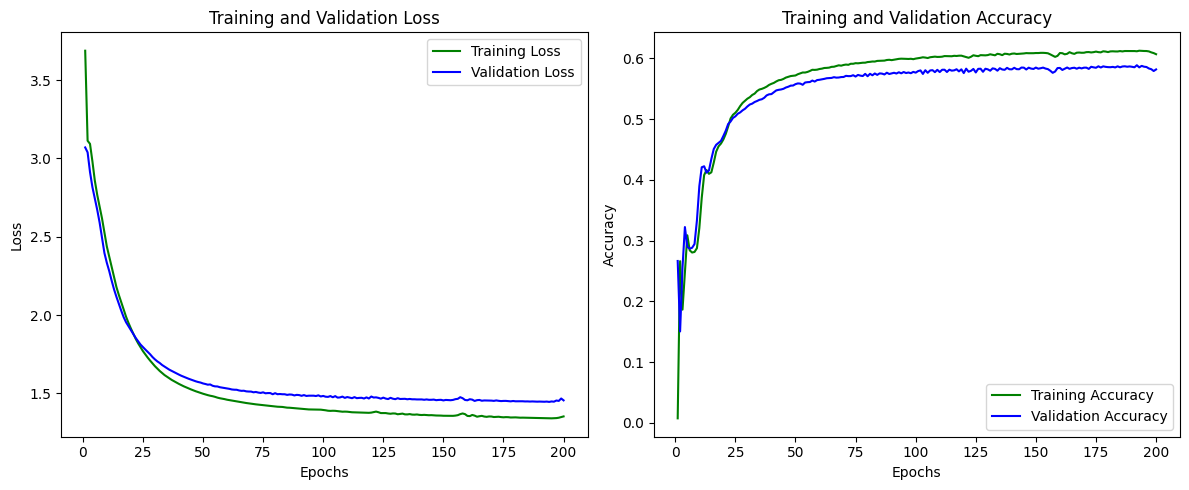

In [10]:
import matplotlib.pyplot as plt

def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_loss, val_loss, train_acc, val_acc)


# Three-Layer GAT:

In [ ]:
class ThreeLayerGAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(ThreeLayerGAT, self).__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=num_heads)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
        self.conv3 = GATConv(hidden_dim * num_heads, out_dim, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


# Graph Convolution Network (GCN):

In [ ]:
class GCNModel(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


# Chebyshev Spectral CNN (ChebNet):

In [ ]:
from torch_geometric.nn import ChebConv

class ChebNet(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, K):
        super(ChebNet, self).__init__()
        self.conv1 = ChebConv(in_dim, hidden_dim, K)
        self.conv2 = ChebConv(hidden_dim, out_dim, K)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
